In [29]:
import os
import sys

project_root = os.getcwd()
while "src" not in os.listdir(project_root):
    project_root = os.path.dirname(project_root)
sys.path.append(project_root)

In [30]:
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from src.pipelines import train_pipeline, inference_pipeline
from src.models import SimpleUNet, SCUNet, DeepSampler
from src.utils.data import MUSDB18Dataset
from src.utils.training import (
    MultiSourceLoss,
    MultiSourceMultiScaleLoss,
    CompositeSpectrogramLoss,
)
import numpy as np
import matplotlib.pyplot as plt
import librosa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

experiments_path = os.path.join(project_root, "experiments")
data_root = os.path.join(project_root, "data")
checkpoint_path = os.path.join(experiments_path, "checkpoints")
scunet_path = os.path.join(checkpoint_path, "scunet.pth")
results_path = os.path.join(experiments_path, "results")
musdb_path = os.path.join(project_root, "data", "musdb18hq", "test")
musdb_files = os.listdir(musdb_path)
musdb_files.sort()

Using device: cuda


In [31]:
deep_sampler = DeepSampler()
x = torch.randn(1, 1, 1025, 173)  # (batch, channels, height, width)
output = deep_sampler(x)  # Salida: (1, 4, 1025, 173)
output.shape

torch.Size([1, 4, 1025, 173])

In [32]:
train_dataset = MUSDB18Dataset(os.path.join(data_root, "processed", "train"))
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True
)
mixture, _ = train_dataset.__getitem__(0)
print("Sample input shape:", mixture.shape)

Sample input shape: torch.Size([1, 1025, 173])


In [33]:
deep_sampler.to(device)
weights = [3.0, 1.0, 1.0, 1.0]
weights = [w / sum(weights) for w in weights]

criterion = MultiSourceLoss(
    weights=weights,
    distance="l1",
)

# Configuración del optimizador.
# Se incrementó ligeramente el weight_decay para ayudar a prevenir overfitting.
optimizer = optim.Adam(deep_sampler.parameters(), lr=1e-3, weight_decay=1e-5)

# Configuración del scheduler.
# Opción 1: StepLR, que reduce la tasa de aprendizaje cada 10 épocas.
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Opción 2 (alternativa): ReduceLROnPlateau, que reduce la tasa de aprendizaje
# cuando la pérdida de validación se estanca.
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Parámetros de entrenamiento
total_epochs = 50         # Se recomienda aumentar el número de épocas para asegurar la convergencia.
phase1_epochs = 10

In [34]:
trained_model, history = train_pipeline(
    model=deep_sampler,
    dataloader=train_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    total_epochs=total_epochs,
    phase1_epochs=phase1_epochs,
)

Epoch 1/50 - Avg Loss: 0.0855 - LR: 1.0e-03 - Time: 11.93s - ETA: 584.41s


Epoch 2/50 - Avg Loss: 0.0446 - LR: 1.0e-03 - Time: 8.40s - ETA: 487.83s


Epoch 3/50 - Avg Loss: 0.0388 - LR: 1.0e-03 - Time: 7.94s - ETA: 442.85s


Epoch 4/50 - Avg Loss: 0.0314 - LR: 1.0e-03 - Time: 8.11s - ETA: 418.32s


Epoch 5/50 - Avg Loss: 0.0362 - LR: 1.0e-03 - Time: 8.30s - ETA: 402.09s


Epoch 6/50 - Avg Loss: 0.0433 - LR: 1.0e-03 - Time: 7.72s - ETA: 384.25s


Epoch 7/50 - Avg Loss: 0.0350 - LR: 1.0e-03 - Time: 7.90s - ETA: 370.39s


Epoch 8/50 - Avg Loss: 0.0445 - LR: 1.0e-03 - Time: 7.73s - ETA: 357.16s


Epoch 9/50 - Avg Loss: 0.0403 - LR: 1.0e-03 - Time: 7.85s - ETA: 345.68s


Epoch 10/50 - Avg Loss: 0.0451 - LR: 1.0e-04 - Time: 8.62s - ETA: 338.01s

Starting second training phase (lr=1e-4)


Epoch 11/50 - Avg Loss: 0.0467 - LR: 1.0e-04 - Time: 7.97s - ETA: 327.86s


Epoch 12/50 - Avg Loss: 0.0242 - LR: 1.0e-04 - Time: 7.91s - ETA: 317.88s


Epoch 13/50 - Avg Loss: 0.0303 - LR: 1.0e-04 - Time: 7.83s - ETA: 307.99s


Epoch 14/50 - Avg Loss: 0.0511 - LR: 1.0e-04 - Time: 7.66s - ETA: 297.96s


Epoch 15/50 - Avg Loss: 0.0313 - LR: 1.0e-04 - Time: 8.21s - ETA: 289.54s


Epoch 16/50 - Avg Loss: 0.0331 - LR: 1.0e-04 - Time: 8.48s - ETA: 281.70s


Epoch 17/50 - Avg Loss: 0.0396 - LR: 1.0e-04 - Time: 8.24s - ETA: 273.32s


Epoch 18/50 - Avg Loss: 0.0268 - LR: 1.0e-04 - Time: 8.07s - ETA: 264.66s


Epoch 19/50 - Avg Loss: 0.0462 - LR: 1.0e-04 - Time: 8.02s - ETA: 255.97s


Epoch 20/50 - Avg Loss: 0.0504 - LR: 1.0e-05 - Time: 8.30s - ETA: 247.78s


Epoch 21/50 - Avg Loss: 0.0498 - LR: 1.0e-05 - Time: 7.98s - ETA: 239.13s


Epoch 22/50 - Avg Loss: 0.0256 - LR: 1.0e-05 - Time: 7.69s - ETA: 230.18s


Epoch 23/50 - Avg Loss: 0.0299 - LR: 1.0e-05 - Time: 8.50s - ETA: 222.28s


Epoch 24/50 - Avg Loss: 0.0410 - LR: 1.0e-05 - Time: 7.69s - ETA: 213.46s


Epoch 25/50 - Avg Loss: 0.0436 - LR: 1.0e-05 - Time: 8.33s - ETA: 205.38s


Epoch 26/50 - Avg Loss: 0.0297 - LR: 1.0e-05 - Time: 8.08s - ETA: 197.04s


Epoch 27/50 - Avg Loss: 0.0331 - LR: 1.0e-05 - Time: 8.04s - ETA: 188.68s


Epoch 28/50 - Avg Loss: 0.0271 - LR: 1.0e-05 - Time: 7.72s - ETA: 180.10s


Epoch 29/50 - Avg Loss: 0.0361 - LR: 1.0e-05 - Time: 7.92s - ETA: 171.72s


Epoch 30/50 - Avg Loss: 0.0356 - LR: 1.0e-06 - Time: 8.16s - ETA: 163.53s


Epoch 31/50 - Avg Loss: 0.0277 - LR: 1.0e-06 - Time: 8.34s - ETA: 155.46s


Epoch 32/50 - Avg Loss: 0.0261 - LR: 1.0e-06 - Time: 7.78s - ETA: 147.05s


Epoch 33/50 - Avg Loss: 0.0373 - LR: 1.0e-06 - Time: 8.07s - ETA: 138.83s


Epoch 34/50 - Avg Loss: 0.0536 - LR: 1.0e-06 - Time: 8.26s - ETA: 130.71s


Epoch 35/50 - Avg Loss: 0.0273 - LR: 1.0e-06 - Time: 7.42s - ETA: 122.22s


Epoch 36/50 - Avg Loss: 0.0436 - LR: 1.0e-06 - Time: 7.73s - ETA: 113.91s


Epoch 37/50 - Avg Loss: 0.0467 - LR: 1.0e-06 - Time: 8.25s - ETA: 105.81s


Epoch 38/50 - Avg Loss: 0.0379 - LR: 1.0e-06 - Time: 7.96s - ETA: 97.62s


Epoch 39/50 - Avg Loss: 0.0336 - LR: 1.0e-06 - Time: 8.30s - ETA: 89.53s


Epoch 40/50 - Avg Loss: 0.0333 - LR: 1.0e-07 - Time: 8.08s - ETA: 81.37s


Epoch 41/50 - Avg Loss: 0.0378 - LR: 1.0e-07 - Time: 7.82s - ETA: 73.17s


Epoch 42/50 - Avg Loss: 0.0316 - LR: 1.0e-07 - Time: 8.08s - ETA: 65.03s


Epoch 43/50 - Avg Loss: 0.0405 - LR: 1.0e-07 - Time: 8.03s - ETA: 56.88s


Epoch 44/50 - Avg Loss: 0.0404 - LR: 1.0e-07 - Time: 7.68s - ETA: 48.70s


Epoch 45/50 - Avg Loss: 0.0310 - LR: 1.0e-07 - Time: 7.90s - ETA: 40.56s


Epoch 46/50 - Avg Loss: 0.0412 - LR: 1.0e-07 - Time: 7.81s - ETA: 32.42s


Epoch 47/50 - Avg Loss: 0.0392 - LR: 1.0e-07 - Time: 7.97s - ETA: 24.31s


Epoch 48/50 - Avg Loss: 0.0374 - LR: 1.0e-07 - Time: 7.67s - ETA: 16.19s


Epoch 49/50 - Avg Loss: 0.0309 - LR: 1.0e-07 - Time: 7.95s - ETA: 8.09s


Epoch 50/50 - Avg Loss: 0.0412 - LR: 1.0e-08 - Time: 8.19s - ETA: 0.00s

Training complete. Total time: 404.613582611084 seconds.


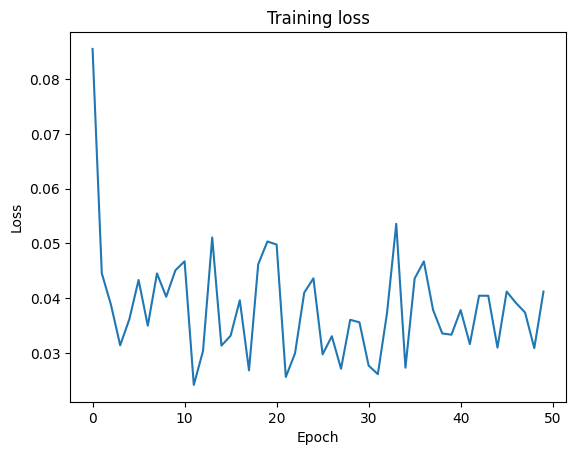

In [35]:
# plot history losses
# history = {"epoch_loss": [], "learning_rate": []}
plt.plot(history["epoch_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()

In [36]:
seconds = 30
N_FFT = 1024
HOP_LENGTH = 512

random_sample = np.random.choice(musdb_files)
sample_path = os.path.join(musdb_path, random_sample)

In [37]:
mixture_path = os.path.join(sample_path, "mixture.wav")
vocals_path = os.path.join(sample_path, "vocals.wav")
bass_path = os.path.join(sample_path, "bass.wav")
drums_path = os.path.join(sample_path, "drums.wav")
other_path = os.path.join(sample_path, "other.wav")

mixture, sr = librosa.load(mixture_path, sr=None)
vocals, _ = librosa.load(vocals_path, sr=None)
bass, _ = librosa.load(bass_path, sr=None)
drums, _ = librosa.load(drums_path, sr=None)
other, _ = librosa.load(other_path, sr=None)

mixture = mixture[: int(seconds * sr)]
vocals = vocals[: int(seconds * sr)]
bass = bass[: int(seconds * sr)]
drums = drums[: int(seconds * sr)]
other = other[: int(seconds * sr)]

mixture_stft = librosa.stft(mixture, n_fft=N_FFT, hop_length=HOP_LENGTH)
vocals_stft = librosa.stft(vocals, n_fft=N_FFT, hop_length=HOP_LENGTH)
bass_stft = librosa.stft(bass, n_fft=N_FFT, hop_length=HOP_LENGTH)
drums_stft = librosa.stft(drums, n_fft=N_FFT, hop_length=HOP_LENGTH)
other_stft = librosa.stft(other, n_fft=N_FFT, hop_length=HOP_LENGTH)

In [38]:
inference_pipeline(
    model=trained_model,
    mixture_path=mixture_path,
    output_path=os.path.join(results_path, f"deep_sampler"),
    device=device,
)

Processing chunks: 100%|██████████| 110/110 [00:02<00:00, 39.88it/s]


Saved vocals to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/deep_sampler/vocals.wav
Saved drums to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/deep_sampler/drums.wav
Saved bass to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/deep_sampler/bass.wav
Saved other to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/deep_sampler/other.wav


{'vocals': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.0158613e-07,
        3.0818132e-06, 1.0761623e-06], dtype=float32),
 'drums': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.75141462e-05, 1.08859334e-04, 2.01888150e-04], dtype=float32),
 'bass': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 9.2860546e-06,
        1.5115988e-05, 1.4426188e-05], dtype=float32),
 'other': array([ 0.        ,  0.        ,  0.        , ..., -0.00699038,
        -0.00727262, -0.00730812], dtype=float32)}

In [39]:
res_vocals_path = os.path.join(results_path, "deep_sampler", "vocals.wav")
res_bass_path = os.path.join(results_path, "deep_sampler", "bass.wav")
res_drums_path = os.path.join(results_path, "deep_sampler", "drums.wav")
res_other_path = os.path.join(results_path, "deep_sampler", "other.wav")

res_vocals, sr = librosa.load(res_vocals_path, sr=None)
res_bass, _ = librosa.load(res_bass_path, sr=None)
res_drums, _ = librosa.load(res_drums_path, sr=None)
res_other, _ = librosa.load(res_other_path, sr=None)

res_vocals = res_vocals[: int(seconds * sr)]
res_bass = res_bass[: int(seconds * sr)]
res_drums = res_drums[: int(seconds * sr)]
res_other = res_other[: int(seconds * sr)]

res_vocals_stft = librosa.stft(res_vocals, n_fft=N_FFT, hop_length=HOP_LENGTH)
res_bass_stft = librosa.stft(res_bass, n_fft=N_FFT, hop_length=HOP_LENGTH)
res_drums_stft = librosa.stft(res_drums, n_fft=N_FFT, hop_length=HOP_LENGTH)
res_other_stft = librosa.stft(res_other, n_fft=N_FFT, hop_length=HOP_LENGTH)

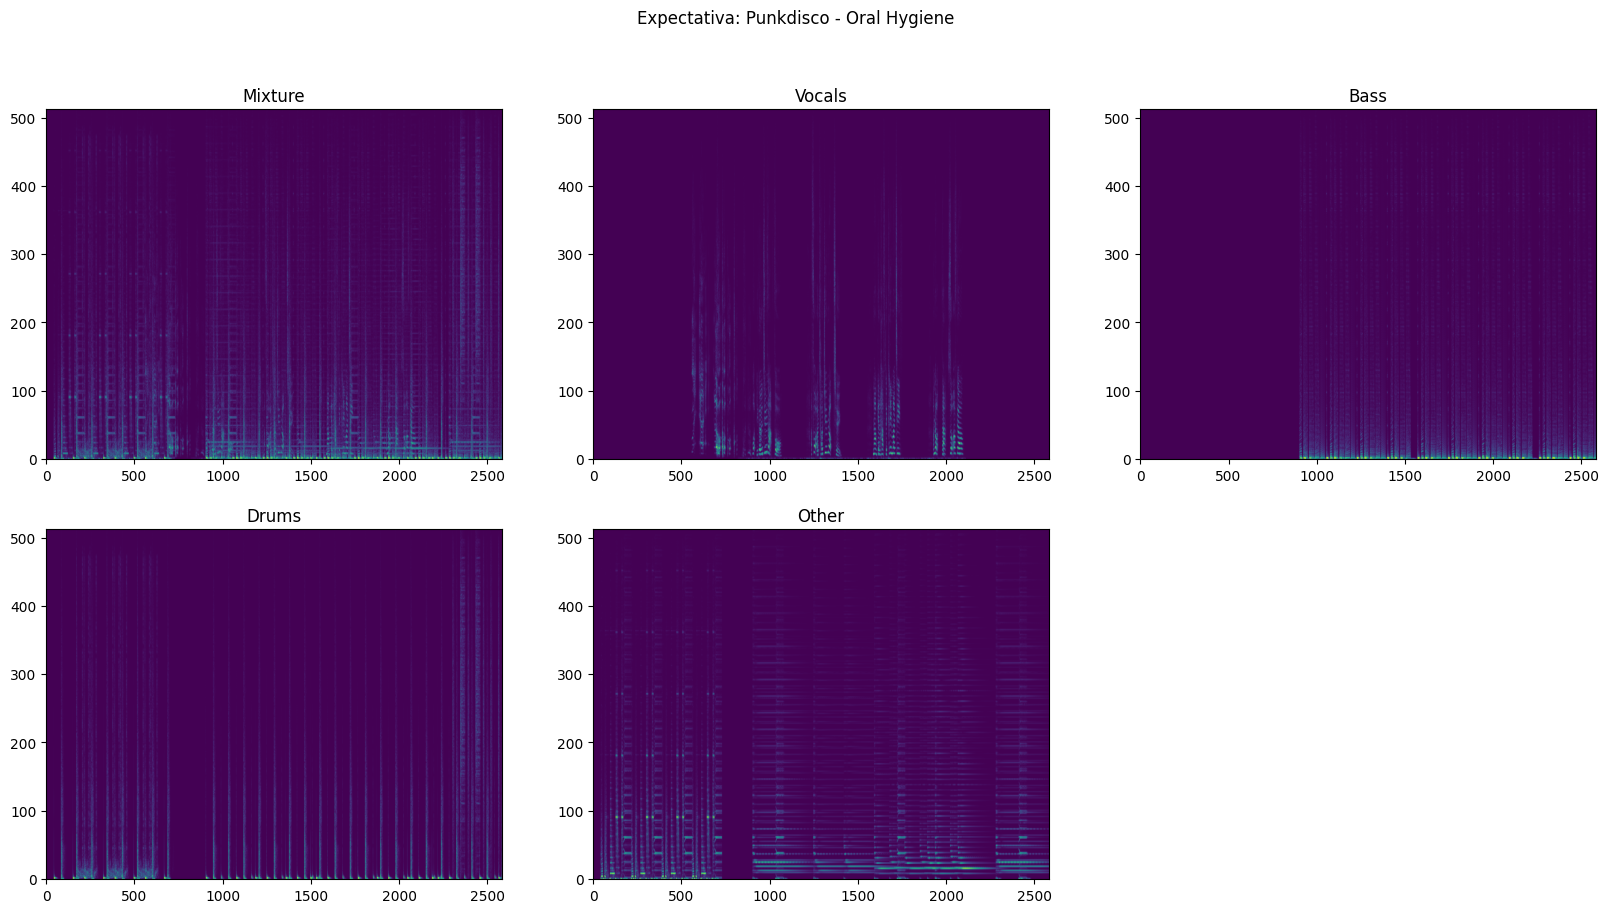

In [40]:
plt.figure(figsize=(20, 10))
plt.suptitle(f"Expectativa: {os.path.basename(sample_path)}")
plt.subplot(2, 3, 1)
plt.title("Mixture")
plt.imshow(np.log1p(np.abs(mixture_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 2)
plt.title("Vocals")
plt.imshow(np.log1p(np.abs(vocals_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 3)
plt.title("Bass")
plt.imshow(np.log1p(np.abs(bass_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 4)
plt.title("Drums")
plt.imshow(np.log1p(np.abs(drums_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 5)
plt.title("Other")
plt.imshow(np.log1p(np.abs(other_stft)), aspect="auto", origin="lower")

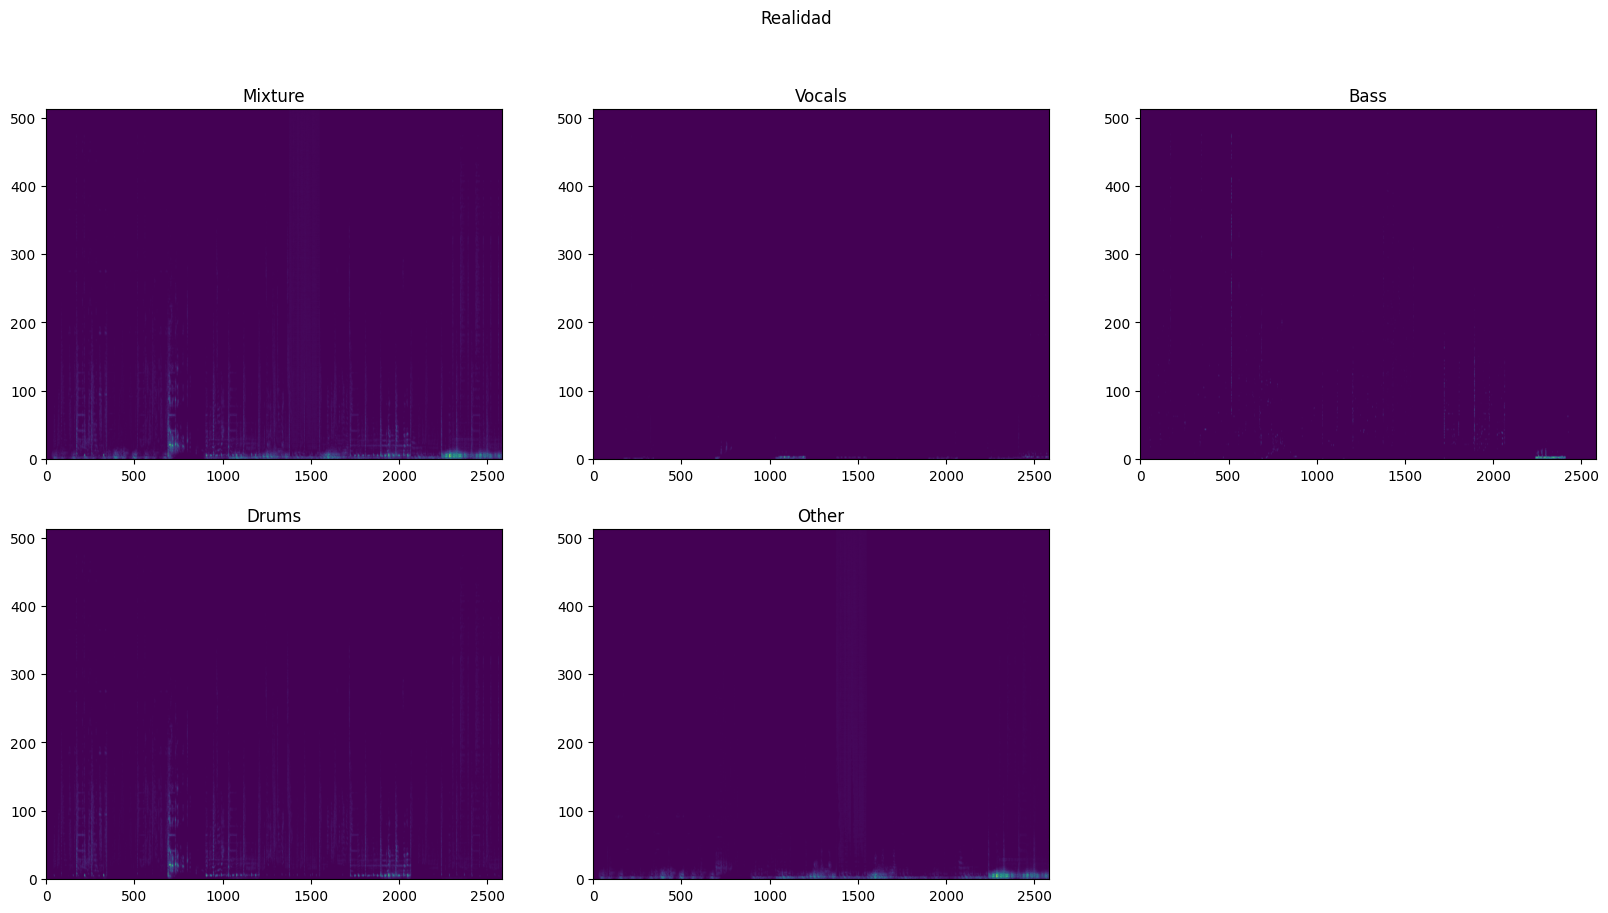

In [41]:
plt.figure(figsize=(20, 10))
plt.suptitle("Realidad")
plt.subplot(2, 3, 1)
plt.title("Mixture")
plt.imshow(
    np.log1p(np.abs(res_bass_stft + res_drums_stft + res_other_stft + res_vocals_stft)),
    aspect="auto",
    origin="lower",
)
plt.subplot(2, 3, 2)
plt.title("Vocals")
plt.imshow(np.log1p(np.abs(res_vocals_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 3)
plt.title("Bass")
plt.imshow(np.log1p(np.abs(res_bass_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 4)
plt.title("Drums")
plt.imshow(np.log1p(np.abs(res_drums_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 5)
plt.title("Other")
plt.imshow(np.log1p(np.abs(res_other_stft)), aspect="auto", origin="lower")

In [42]:
torch.save(
    trained_model.state_dict(),
    os.path.join(project_root, "experiments", "checkpoints", f"deep_sampler.pth"),
)
print("Model checkpoint saved.")

Model checkpoint saved.
